# Hyperparameter tuning
List of hyperparameters:
- parameters for the homeostatic gain -> homeo (h1, h2)
- architecture of the network
    - number of layers
    - number of neurons -> nbclust (n1, n2, ...)
    - size of the receptive fields -> R (R1, R2, ...)
    - timescales of the neurons -> tau (tau1, tau2, ...)

# Poker DVS

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd '../HOTS'

from network import network
from tools import get_dataset_info, get_loader, HOTS_Dataset, fit_MLR, predict_MLR, score_classif_events, score_classif_time, fit_histo, predict_histo
import os, tonic

/home/INT/grimaldi.a/Documents/projets/HOTS/newhots/HOTS


### For Poker DVS

number of samples in the trainset: 48
number of samples in the testset: 20
----------------------------------------
number of samples in each class for the trainset: [12. 12. 12. 12.]
number of samples in each class for the testset: [5. 5. 5. 5.]
----------------------------------------


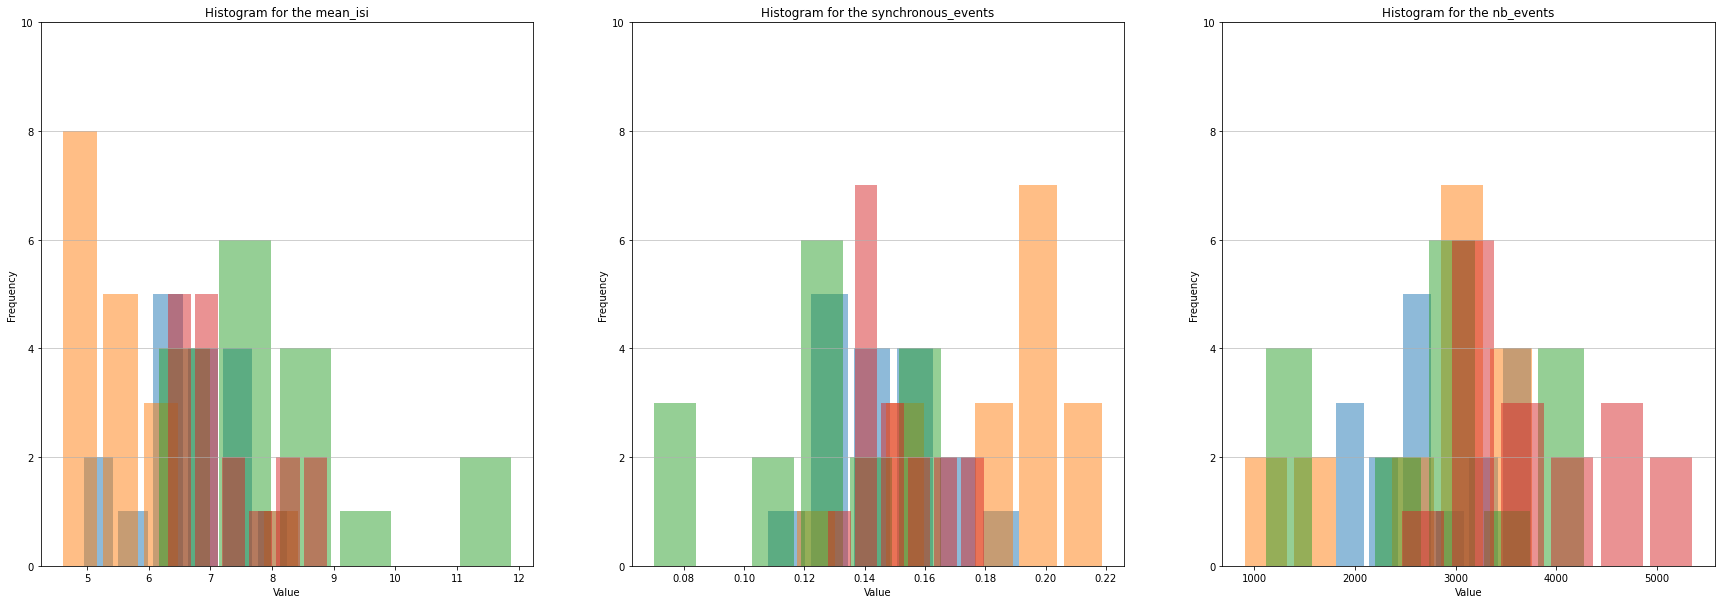

In [2]:
trainset = tonic.datasets.POKERDVS(save_to='../../Data', train = True, transform = tonic.transforms.NumpyAsType(int))
testset = tonic.datasets.POKERDVS(save_to='../../Data', train = False, transform = tonic.transforms.NumpyAsType(int))
get_dataset_info(trainset,testset, distinguish_labels=True);

### How to determine the number of layers? 
It may depend on the complexity of the movement:
- only one layer -> you're not able to trace events that are recovered by other ones.
- if you have different layers and timescales then you can make a multiscale analysis (have a timescale of the last layer that covers the whole recording? It is the case for the classifier, is having 2 tau similar gives redundant information?)
- the first layer should capture fast and simple features -> edges of objects, features of structures (bars, dots, edges in general) 

In [3]:
prototau = .3
sensor_size = trainset.sensor_size
name = 'homhots'
tau = (prototau*2,prototau*8)
nbclust = (8,16)
timestr = '2022-01-25_poker'
homeo = (4,0)

In [10]:
events, target = next(iter(loader))
print(events.squeeze().shape)

torch.Size([2637, 4])


loading a network with name:
 ../Records/models/2022-01-25_poker_homhots_(4, 0)_[8, 16]_[0.6, 2.4]_[2, 4].pkl


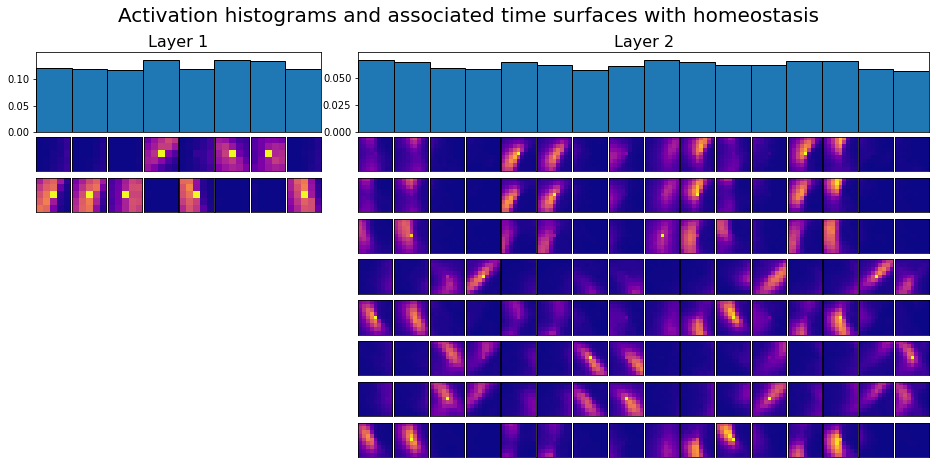

In [4]:
hots = network(name = name, tau = tau, homeo = homeo, nbclust = nbclust, timestr = timestr, camsize=(sensor_size[0], sensor_size[1]))
loader = get_loader(trainset)
hots.running(loader, trainset.ordering, trainset.classes, learn=True, train=True)
hots.plotlayer();

In [5]:
tau_cla = 15
hots.running(loader, trainset.ordering, trainset.classes, train=True)
model, loss = fit_MLR(tau_cla, network = hots)

this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-25_poker_homhots_(4, 0)_[8, 16]_[0.6, 2.4]_[2, 4]_None/
Name of the model: 
 ../Records/models/2022-01-25_poker_homhots_(4, 0)_[8, 16]_[0.6, 2.4]_[2, 4]_15_None_LR.pkl


this dataset have already been processed, check at: 
 ../Records/output/test/2022-01-25_poker_homhots_(4, 0)_[8, 16]_[0.6, 2.4]_[2, 4]_None/
../Records/output/classif/2022-01-25_poker_homhots_(4, 0)_[8, 16]_[0.6, 2.4]_[2, 4]_15_None_None_LR.pkl
Mean accuracy: 98.7%
Accuracy with classification at the last event: 100%


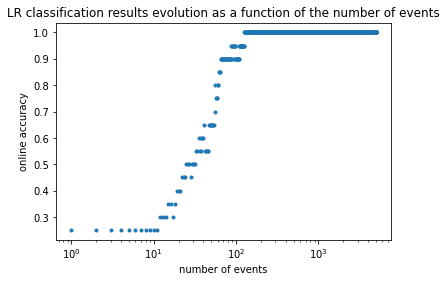

In [6]:
loader = get_loader(testset)
hots.running(loader, trainset.ordering, trainset.classes, train=False)
likelihood, true_target, timestamps = predict_MLR(model, tau_cla, network = hots)
meanac, onlinac, lastac, truepos, falsepos = score_classif_events(likelihood, true_target)
print(f'Accuracy with classification at the last event: {int(lastac*100)}%')

  0%|                                                                                                                                                         | 0/20 [00:00<?, ?it/s]/home/INT/grimaldi.a/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/INT/grimaldi.a/.local/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 71.78it/s]
/home/INT/grimaldi.a/Documents/projets/HOTS/newhots/HOTS/tools.py:439: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


Mean accuracy: 93.4%
Accuracy with classification at the last event: 100%


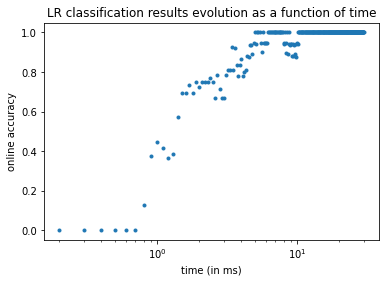

In [10]:
meanac, onlinac, lastac, truepos, falsepos = score_classif_time(likelihood, true_target, timestamps, timestep=100)
print(f'Accuracy with classification at the last event: {int(lastac*100)}%')

In [13]:
histo, label = fit_histo(hots)
for k in [1,3,6,9]:
    accuracy = predict_histo(hots, histo, label, k=k)
    print(f'Accuracy for {k}-NN classifier: {accuracy*1e2}%')

Number of training samples: 48


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 2429.72it/s]


Number of testing samples: 20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 2315.12it/s]


Accuracy for 1-NN classifier: 60.0%
Number of testing samples: 20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1490.88it/s]


Accuracy for 3-NN classifier: 70.0%
Number of testing samples: 20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1885.50it/s]


Accuracy for 6-NN classifier: 65.0%
Number of testing samples: 20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 2015.18it/s]

Accuracy for 9-NN classifier: 60.0%


### Trying different parameters for homeostasis

In [14]:
import numpy as np
from HOTS.tools import fit_histo, predict_histo

vector_h1 = np.arange(0,4,.2)
vector_h2 = np.arange(0,1.5,0.5)

accuracy1 = np.zeros([len(vector_h1), len(vector_h2)])
accuracy3 = np.zeros([len(vector_h1), len(vector_h2)])
accuracy6 = np.zeros([len(vector_h1), len(vector_h2)])
for count1, h1 in enumerate(vector_h1):
    for count2, h2 in enumerate(vector_h2):
        homeo = (h1,h2)
        hots = network(name = name, tau = tau, homeo = homeo, timestr = timestr, camsize=(sensor_size[0], sensor_size[1]))
        loader = get_loader(trainset)
        hots.running(loader, trainset.ordering, trainset.classes, learn=True, train=True)
        hots.running(loader, trainset.ordering, trainset.classes, train=True)
        loader = get_loader(testset)
        hots.running(loader, trainset.ordering, trainset.classes, train=False)
        histo, label = fit_histo(hots)
        accuracy1[count1,count2] = predict_histo(hots, histo, label, k=1)
        accuracy3[count1,count2] = predict_histo(hots, histo, label, k=3)
        accuracy6[count1,count2] = predict_histo(hots, histo, label, k=6)

IndexError: index 2 is out of bounds for axis 0 with size 2

## Output of HOTS info

In [ ]:
jitter = None
timesurface_size = (hots.TS[0].camsize[0], hots.TS[0].camsize[1], hots.L[-1].kernel.shape[1])
path_to_dataset = f'../Records/output/train/{hots.get_fname()}_None/'
trainoutset = HOTS_Dataset(path_to_dataset, timesurface_size, transform=tonic.transforms.NumpyAsType(int))
path_to_dataset = f'../Records/output/test/{hots.get_fname()}_{jitter}/'
testoutset = HOTS_Dataset(path_to_dataset, timesurface_size, transform=tonic.transforms.NumpyAsType(int))
get_dataset_info(trainoutset,testoutset)